In [1]:
import os
import sys
import random

from pathlib import Path
root = Path('..').resolve()
sys.path.insert(0, str(root))

import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

import src.data.augmentation as aug
import src.data.image_processing as ip
from src.data.adversarial_erasing_io import load_accumulated_heatmap
import src.attributions.gradcam as gradcam
from src.models.torch import Xception

/home/federici/miniconda3/envs/polarlows/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


data/train/pos/03cb6a_20191204T073021_20191204T073211_mos_rgb.png


/tmp/ipykernel_936600/3402544098.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(f"out/checkpoints/001/adver_it{i}.ckpt", map_location="cpu")
/home/fe

Iteration 0. Pred: 1


/home/federici/polar-lows-detection-forecasting-deep-learning/src/data/adversarial_erasing_io.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(random.c

Iteration 1. Pred: 1
Iteration 2. Pred: 1
Iteration 3. Pred: 0
Iteration 4. Pred: 1
Iteration 5. Pred: 1
Iteration 6. Pred: 0
Iteration 7. Pred: 1
Iteration 8. Pred: 1
Iteration 9. Pred: 1
Iteration 10. Pred: 0


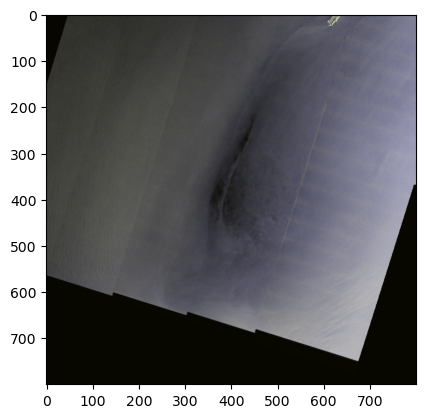

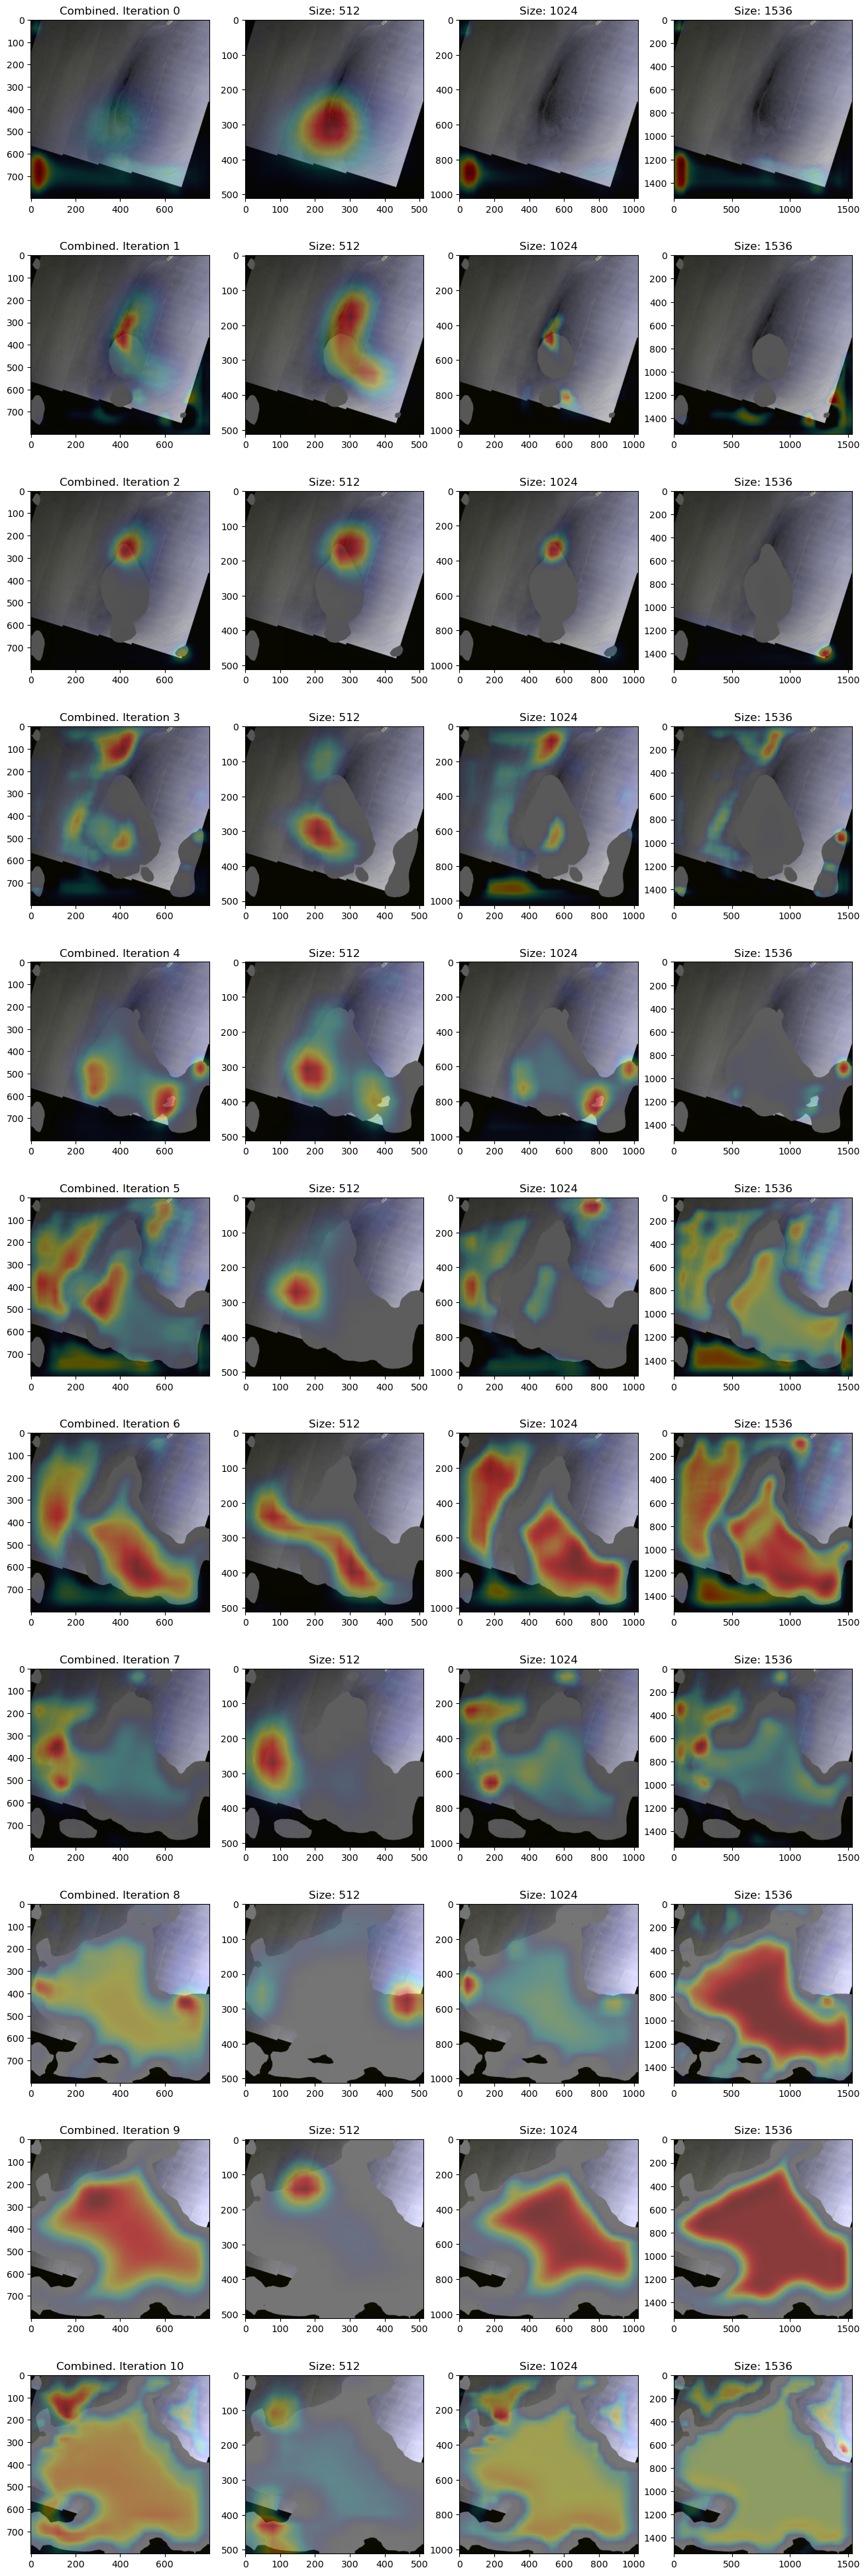

In [2]:
img_path = "data/train/pos/03cb6a_20191204T073021_20191204T073211_mos_rgb.png"
train_dir = "data/train"
category = 'pos' # random.choice(['pos', 'neg'])
chosen_image = random.choice(os.listdir(os.path.join(train_dir, category)))
# img_path = os.path.join(train_dir, category, chosen_image)
print(img_path)
img = Image.open(img_path)

size = 800
aug_config = aug.AugConfig( 
    resize_width = size,  # 512 = 64 * 8 
    resize_height = size, 
    mean = [0.2872, 0.2872, 0.4595],
    std = [0.1806, 0.1806, 0.2621]
)
val_compose = aug.to_compose(aug_config, stage="val")
img_tens = val_compose(img).unsqueeze(0).to("cuda")
plt.imshow(ip.normalize_image_to_range(img_tens.squeeze(0).permute(1, 2, 0).cpu().numpy()))

sizes = [512, 512*2, 512*3]
max_iteration = 10
nrows = max_iteration
ncols = 1 + len(sizes)
fig, ax = plt.subplots(nrows+1, ncols, figsize=(4*ncols, 5*nrows))
for i in range(max_iteration + 1):
    ckpt = torch.load(f"out/checkpoints/001/adver_it{i}.ckpt", map_location="cpu")
    state_dict = ckpt["state_dict"]
    
    new_state = {}
    for k,v in state_dict.items():
        name = k.replace("model.", "")
        new_state[name] = v
    
    model = Xception(num_classes=2)
    model.load_state_dict(new_state)
    model.eval();
    model.cuda()

    if i > 0:
        accumulated_heatmap = load_accumulated_heatmap(
            base_heatmaps_dir="out/heatmaps",
            img_name=os.path.basename(img_path),
            label=1,
            iteration=i,
        )

        img_tens = ip.erase_region_using_heatmap(
            image=img_tens,
            heatmap=accumulated_heatmap,
            threshold=0.7,
        )

    gc = gradcam.GradCAM(model, device="cuda")
    heatmap = gc.generate_super_heatmap(
        img_tens,
        target_size=(512,512),
        sizes=sizes,
        target_class=1,
    )

    img_overlay = gc.overlay_heatmap(img_tens, heatmap)

    img_resized = F.interpolate(
        img_tens, size=(512,512), mode="bilinear", align_corners=False
    )

    pred = torch.argmax(model(img_resized)).item()
    print(f"Iteration {i}. Pred: {pred}")

    ax[i, 0].set_title(f"Combined. Iteration {i}")
    ax[i, 0].imshow(img_overlay.permute(1, 2, 0).cpu().numpy())

    for j, s in enumerate(sizes):
        img_resized_specific = F.interpolate(
            img_tens, size=(s,s), mode="bilinear", align_corners=False
        )
        specific_heatmap = gc.generate_heatmap(img_resized_specific, target_class=1)
        specific_overlay = gc.overlay_heatmap(img_resized_specific, specific_heatmap)
        ax[i, j+1].set_title(f"Size: {s}")
        ax[i, j+1].imshow(specific_overlay.permute(1,2,0).cpu().numpy())